In [2]:
import re
import string


def clean_text(text):
    # Remove unicode characters
    text = re.sub('[^\x00-\x7F]+', '', text)
    # Convert to python ASCII string
    text = str(text.encode('ascii'))
    # Convert to lowercase
    text = text.lower()
    # Remove new line characters
    text = text.replace('\n',' ')
    # Remove links
    text = re.sub('http\S+', '', text)
    # Remove punctuation 
    to_remove = string.punctuation.replace("'",'')
    text = re.sub('['+to_remove+']+', '', text)
    # Remove numbers
    text = re.sub('\d', '', text)
    return text
        

def clean_dictionary(dictionary):
    for _, value in dictionary.items():
        value['title'] = clean_text(value['title'])
        comments = value['comments']
        for i in range(len(comments)):
             comments[i] = clean_text(comments[i])
        value['comments'] = comments
    return dictionary

def pos_tag(doc):
    pos = []
    for d in doc:
        pos.append(nltk.pos_tag(d))
    return pos


def eliminate_pos(pos, chosen):
    keep_list = []
    for d in pos:
        keep = [word[0] for word in d if word[1] in chosen]
        keep_list.append(keep)
    return keep_list

# Retrieve data from MongoDB

In [166]:
import pymongo
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client.reddit_database
collection_top = db.reddit_top
collection_contro = db.reddit_contro

In [167]:
collection_contro.count()

2000

In [178]:
def stem(string):
    words = string.split()
    stemmed = []
    for word in words:
        stemmed.append(PorterStemmer().stem(word))
    return ' '.join(stemmed)


def create_docs(collection, how, to_stem=False):
    docs = []
    for d in collection.find():
        if how == 'sep':
            if to_stem:
                docs.append(stem(clean_text(d['title'])))
            else:
                docs.append(clean_text(d['title']))
            if to_stem:
                comments_only = [stem(clean_text(x[0])) for x in d['comments']]
            else:
                comments_only = [clean_text(x[0]) for x in d['comments']]
            docs.extend(comments_only)
        else:
            if to_stem:
                title = stem(title)
            else:
                title = clean_text(d['title'])
            comments = ' '
            for c in d['comments']:
                if to_stem:
                    comments = comments + ' ' + stem(clean_text(c[0]))
                else:
                    comments = comments + ' ' + clean_text(c[0])
            docs.append(title + comments)
    return docs

In [188]:
contro_tfidf = list(set(create_docs(collection_contro, how ='together')))
top_tfidf = list(set(create_docs(collection_top, how ='together')))

In [189]:
print len(contro_tfidf) + len(top_tfidf)

3729


## Get rid of posts in both document lists

In [191]:
# RUN TWICE
count = 0
for c in contro_tfidf:
    for t in top_tfidf:
        if c == t:
            count += 1
            top_tfidf.remove(t)
print count

0


# NMF

Topic #0:
said didn sex girl night friend went head mom thought room bed sleep tell phone away told asked face home
Topic #1:
direct link submitted users mobile benefit image feedback exist source op bread filter tree alien penny moon penguin garlic oreo
Topic #2:
game games play played overwatch playing uncharted pc witcher blizzard multiplayer player new ps souls fun thrones physics gaming doom
Topic #3:
trailer dory finding nemo ghostbusters trailers sea wait original lions movie pixar funny gonna new excited nieces looks jokes solid
Topic #4:
movie film movies films watch ghostbusters character star story sequel characters seen plot wars scene batman dc trailers cast marvel
Topic #5:
cat cats cute kitten kitty human meow birthday ocelot booty adorable magazine ass declawed catnip owner dream claws hammock albert
Topic #6:
feedback bot china war isis summary tldrs pms keywords constructive faq admin iran extended reduced far theory welcome replies original
Topic #7:
man black orange

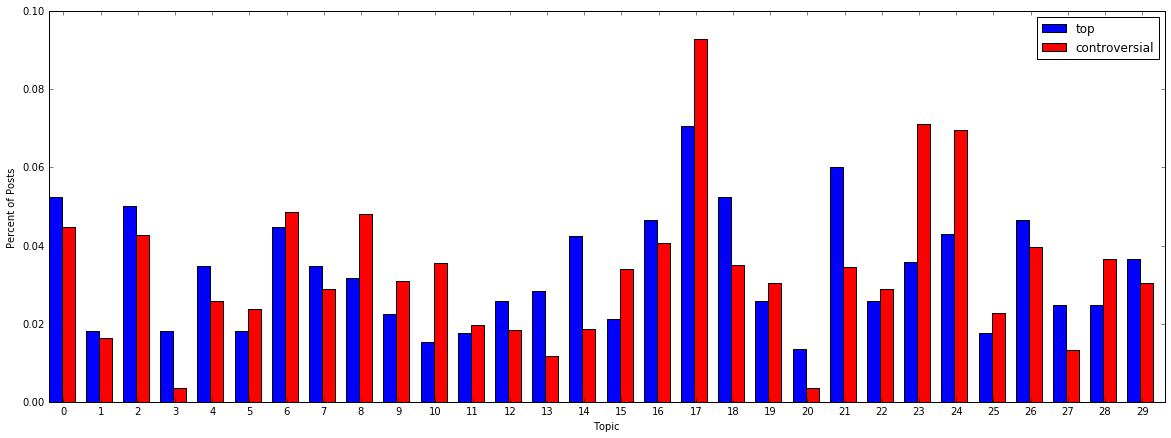

In [477]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
%matplotlib inline
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

NUM_TOPICS = 30
NUM_WORDS = 20
TOPIC_THRESHOLD = 0.1

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1),
                                   lowercase = True,
                                   stop_words='english',
                                   token_pattern='\\b[a-z][a-z]+\\b',
                                   max_df=0.2, min_df=3)
dtm_tfidf = tfidf_vectorizer.fit_transform((top_tfidf + contro_tfidf))

model = NMF(n_components = NUM_TOPICS)
nmf = model.fit(dtm_tfidf)
nmf_transformed = nmf.transform(dtm_tfidf)


def print_top_words(model, feature_names, n_top_words):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topics = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topic_list.append(topics)
        print(topics)
    return topic_list

print_top_words(nmf, tfidf_vectorizer.get_feature_names(), NUM_WORDS)


count = 0
topics_contro = []
for row in nmf_transformed[:len(contro_tfidf)]:
    sort = np.sort(row)[::-1]
    if (sort[0] / sort[1]) > TOPIC_THRESHOLD:
        topics_contro.append(np.argmax(row))
    else:
        count += 1


count2 = 0
topics_top = []
for row in nmf_transformed[len(contro_tfidf):]:
    sort = np.sort(row)[::-1]
    if (sort[0] / sort[1]) > TOPIC_THRESHOLD:
        topics_top.append(np.argmax(row))
    else:
        count2 += 1

print 'posts lost: ', (count+count2)
print 'posts included: ', (len(nmf_transformed) - count - count2)

topic_count_top2 = Counter(topics_top)
topic_count_contro2 = Counter(topics_contro)

y_top2 = [(topic_count_top2[topic] / float(len(topics_top))) for topic in topic_count_top2.keys()]
y_contro2 = [(topic_count_contro2[topic] / float(len(topics_contro))) for topic in topic_count_contro2.keys()]
xs = np.arange(0,len(y_top2))

plt.figure(figsize=(20,7))
plt.bar(xs, y_top2, 0.35, label = 'top', color='b')
plt.bar(xs + 0.35, y_contro2, 0.35, label = 'controversial', color='r')
plt.xlabel('Topic')
plt.ylabel('Percent of Posts')
plt.xticks(xs + 0.4,xs)
plt.legend()
plt.xlim(0,len(y_top2))

print 'Total variance: ', round(sum(np.array(y_top2) - np.array(y_contro2)),20)

In [396]:
indices = np.where(np.array(topics_contro) == 27.)[0]
print indices
print contro_tfidf[23]
for index in indices:
#     print contro_tfidf[index]
    print 'cat' in contro_tfidf[index]
#     print

[  23  121  140  181  223  226  253  326  335  350  361  377  388  421  432
  549  590  631  644  685  711  746  772  773  777  816  830  901  914  927
  944  950  982  994 1003 1020 1023 1024 1028 1056 1096 1124]
mr gong recently struck a deal with humane society international an animalrights group that has begun a campaign against dog farms in south korea 
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False
False
False
False


Topic #0:
said didn sex girl night friend went head mom thought
Topic #1:
direct link submitted users mobile benefit image feedback exist source
Topic #2:
game games play played overwatch playing uncharted pc witcher blizzard
Topic #3:
trailer dory finding nemo ghostbusters trailers sea wait original lions
Topic #4:
movie film movies films watch ghostbusters character star story sequel
Topic #5:
cat cats cute kitten kitty human meow birthday ocelot booty
Topic #6:
feedback bot china war isis summary tldrs pms keywords constructive
Topic #7:
man black orange old oh white ugly god im big
Topic #8:
looks delicious picture face cool damn amazing friend bad looking
Topic #9:
car cars driving drive lane driver speed traffic parking truck
Topic #10:
dog dogs puppy cute pup owner pupper adorable breed animal
Topic #11:
books book read reading series story dan world fantasy characters
Topic #12:
season episode watch shows tv characters seasons series netflix episodes
Topic #13:
ama comments tag

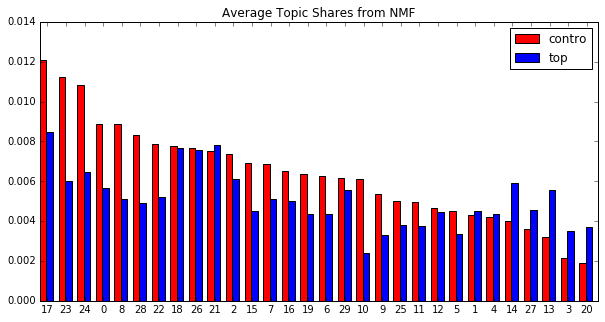

In [479]:
avg_across_topics_contro = np.mean(nmf_transformed[:len(contro_tfidf)], axis=0)
avg_across_topics_top = np.mean(nmf_transformed[len(contro_tfidf):], axis=0)

xss = np.arange(len(avg_across_topics_contro))
wi = zip(avg_across_topics_contro, xss)
wi_sorted = sorted(list(wi), reverse=True)
sorted_contro = np.array([x[0] for x in wi_sorted])
sorted_index = np.array([x[1] for x in wi_sorted])
wit = zip(avg_across_topics_top, xss)
sorted_top = []
for i in sorted_index:
    num = [x[0] for x in wit if x[1] == i]
    sorted_top.append(num[0])
sorted_top = np.array(sorted_top)

plt.figure(figsize=(10,5))
plt.bar(xss, sorted_contro, 0.35, label = 'contro', color='r')
plt.bar(xss + 0.35, sorted_top, 0.35, label = 'top', color='b')
plt.xticks(xss + 0.4,sorted_index)
plt.legend()
plt.title('Average Topic Shares from NMF')

topic_words = print_top_words(nmf, tfidf_vectorizer.get_feature_names(), 10)
topic_words = [str(word) for word in topic_words]

# Save data to .tsv file
np.set_printoptions(precision=8, suppress=True)
complete = np.column_stack((topic_words, np.round(sorted_index,1), sorted_contro, sorted_top))
# print complete

np.savetxt('reddit.csv',complete, delimiter=',',fmt = ('%s','%s','%s','%s'), header='TopicWord,TopicNum,Controversial,Popular', comments='')

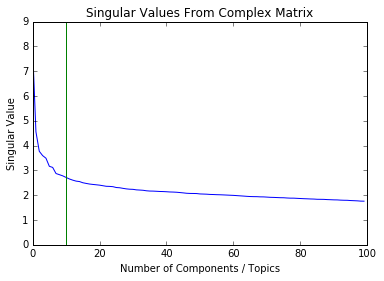

In [473]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(dtm_tfidf, n_components=100, n_iter=5,
                              random_state=4444)

plt.plot(Sigma)
plt.plot([10,10],[0,9])
plt.title('Singular Values From Complex Matrix')
plt.xlabel('Number of Components / Topics')
plt.ylabel('Singular Value')


# Clustering

In [243]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
y_pred = km.fit_predict(nmf_transformed)

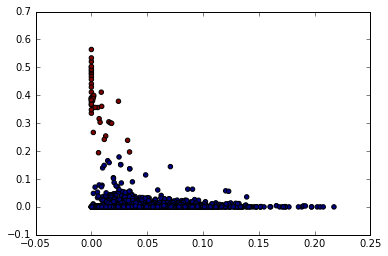

In [244]:
plt.scatter(nmf_transformed[:,0], nmf_transformed[:,1], c=y_pred)

# Classifier

In [ ]:
nmf_transformed[]